In [37]:
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.decomposition import PCA
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold, train_test_split


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.graph_objs as go

import time
import random

In [2]:
data_path = '../input/'
total_train_data = pd.read_csv(data_path + 'train_dataset.csv')
test_data = pd.read_csv(data_path + 'test_dataset.csv')
sample_sub = pd.read_csv(data_path + 'submit_example.csv')

In [3]:
train_test_split_seed = 13400
train_data, local_test_data = train_test_split(total_train_data, test_size=0.2, random_state=train_test_split_seed, shuffle=True)

In [4]:
train_data.columns = ['uid','true_name_flag','age','uni_student_flag','blk_list_flag',\
                     '4g_unhealth_flag','net_age_till_now','top_up_month_diff','top_up_amount',\
                     'recent_6month_avg_use','total_account_fee','curr_month_balance',\
                     'curr_overdue_flag','cost_sensitivity','connect_num','freq_shopping_flag',\
                     'recent_3month_shopping_count','wanda_flag','sam_flag','movie_flag',\
                     'tour_flag','sport_flag','online_shopping_count','express_count',\
                     'finance_app_count','video_app_count','flight_count','train_count',\
                     'tour_app_count','score']

local_test_data.columns = train_data.columns
test_data.columns = train_data.columns[:-1]

In [5]:
#age and net_age_in_month ---> 入网时的年龄 --- useless
#top up amount, 充值金额是整数，和小数，应该对应不同的充值途径？

def produce_offline_feat(train_data):
    train_data['top_up_amount_offline'] = 0
    train_data['top_up_amount_offline'][(train_data['top_up_amount'] % 10 == 0)&\
                               train_data['top_up_amount'] != 0] = 1
    return train_data

train_data = produce_offline_feat(train_data)
local_test_data = produce_offline_feat(local_test_data)
test_data = produce_offline_feat(test_data)

In [6]:
def produce_fee_rate(train_data):
    #看importance，当月话费 和最近半年平均话费都很高，算一下当月/半年 -->稳定性
    train_data['current_fee_stability'] = \
    train_data['total_account_fee']/(train_data['recent_6month_avg_use'] + 1)
    
    #当月话费/当月账户余额
    train_data['use_left_rate'] = \
    train_data['total_account_fee']/(train_data['curr_month_balance'] + 1)
    return train_data

train_data = produce_fee_rate(train_data)
local_test_data = produce_fee_rate(local_test_data)
test_data = produce_fee_rate(test_data)

In [7]:
nfolds = 5
SEED = 2019

train_label = train_data['score']
local_test_label = local_test_data['score']

folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=SEED)

In [8]:
X_train = train_data.drop(['uid','score','blk_list_flag'], axis=1)
X_local_test = local_test_data.drop(['uid','score','blk_list_flag'], axis=1)
X_test = test_data.drop(['uid','blk_list_flag'], axis=1)
y = train_label

In [42]:
def train_model(X_train, X_local_test, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(X_train.shape[0])
    local_test = np.zeros(X_local_test.shape[0])
    cv_pred = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    splits = folds.split(X_train, y)

    for i, (train_idx, valid_idx) in enumerate(splits):
        
        print('Fold', i, 'started at', time.ctime())
        X_train_fold_old, X_valid_fold = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
        y_train_fold_old, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        
        #no oversampling
        #X_train_fold,y_train_fold = SMOTE(random_state=1997, ratio=0.5).fit_resample(X_train_fold_old, y_train_fold_old.ravel())
        X_train_fold,y_train_fold = X_train_fold_old, y_train_fold_old
        print("After OverSampling, counts of label '1': {}".format(sum(y_train_fold==1)))
        print("After OverSampling, counts of label '0': {}".format(sum(y_train_fold==0)))
        
        if model_type == 'lgb':
            dtrain = lgb.Dataset(X_train_fold, label=y_train_fold)
            dvalid = lgb.Dataset(X_valid_fold, label=y_valid_fold)
            
            model = lgb.train(params,
                    dtrain,
                    num_boost_round=10000,
                    valid_sets = [dtrain, dvalid],
                    verbose_eval=500,
                    early_stopping_rounds=50)
            
            y_pred_valid_fold = model.predict(X_valid_fold)
            y_local_pred = model.predict(X_local_test, num_iteration=model.best_iteration)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold, feature_names=X_train.columns)
            dvalid = xgb.DMatrix(data=X_valid_fold, label=y_valid_fold, feature_names=X_train.columns)

            watchlist = [(dtrain, 'train'), (dvalid, 'valid_data')]
            model = xgb.train(dtrain=dtrain, num_boost_round=10000, 
                              evals=watchlist, early_stopping_rounds=50, verbose_eval=500, 
                              params=params)
            y_pred_valid_fold = model.predict(xgb.DMatrix(X_valid_fold, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_local_pred = model.predict(xgb.DMatrix(X_local_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
            
        if model_type == 'cat':
            model = CatBoostRegressor(early_stopping_rounds=50, **params)
            model.fit(X_train_fold, y_train_fold, 
                      eval_set=(X_valid_fold, y_valid_fold), cat_features=[], 
                      verbose=500)

            y_pred_valid_fold = model.predict(X_valid_fold)
            y_local_pred = model.predict(X_local_test)
            y_pred = model.predict(X_test)
            
            
        oof[valid_idx] = y_pred_valid_fold.reshape(-1,)
        scores.append(mean_absolute_error(y_valid_fold, y_pred_valid_fold))
        print("Fold " + str(i) + " mean_absolute_error: ", mean_absolute_error(y_valid_fold, y_pred_valid_fold))

        if averaging == 'usual':
            local_test += y_local_pred
            cv_pred += y_pred
        elif averaging == 'rank':
            local_test += pd.Series(y_local_pred).rank().values
            cv_pred += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = i + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
        if model_type == 'xgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.get_score().values()
            fold_importance["fold"] = i + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
        if model_type == 'cat':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.get_feature_importance()
            fold_importance["fold"] = i + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    local_test /= nfolds
    cv_pred /= nfolds
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    
    feature_importance["importance"] /= nfolds
    if plot_feature_importance:
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('Features (avg over folds)');

        #return oof, prediction, feature_importance
    return oof, local_test, cv_pred, scores
    
    

/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Fold 0 started at Sat Mar  9 10:19:05 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 14.5125	valid_1's l1: 15.0265
[1000]	training's l1: 14.0112	valid_1's l1: 14.8092
[1500]	training's l1: 13.7117	valid_1's l1: 14.7406
[2000]	training's l1: 13.4714	valid_1's l1: 14.7123
[2500]	training's l1: 13.2856	valid_1's l1: 14.7045
Early stopping, best iteration is:
[2483]	training's l1: 13.2924	valid_1's l1: 14.704
Fold 0 mean_absolute_error:  14.703970541153511
Fold 1 started at Sat Mar  9 10:19:09 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 14.4835	valid_1's l1: 15.0742
[1000]	training's l1: 13.9975	valid_1's l1: 14.8459
[1500]	training's l1: 13.7022	valid_1's l1: 14.792
[2000]	training's l1: 13.4723	valid_1's l1: 14.7681
[2500]	training's l

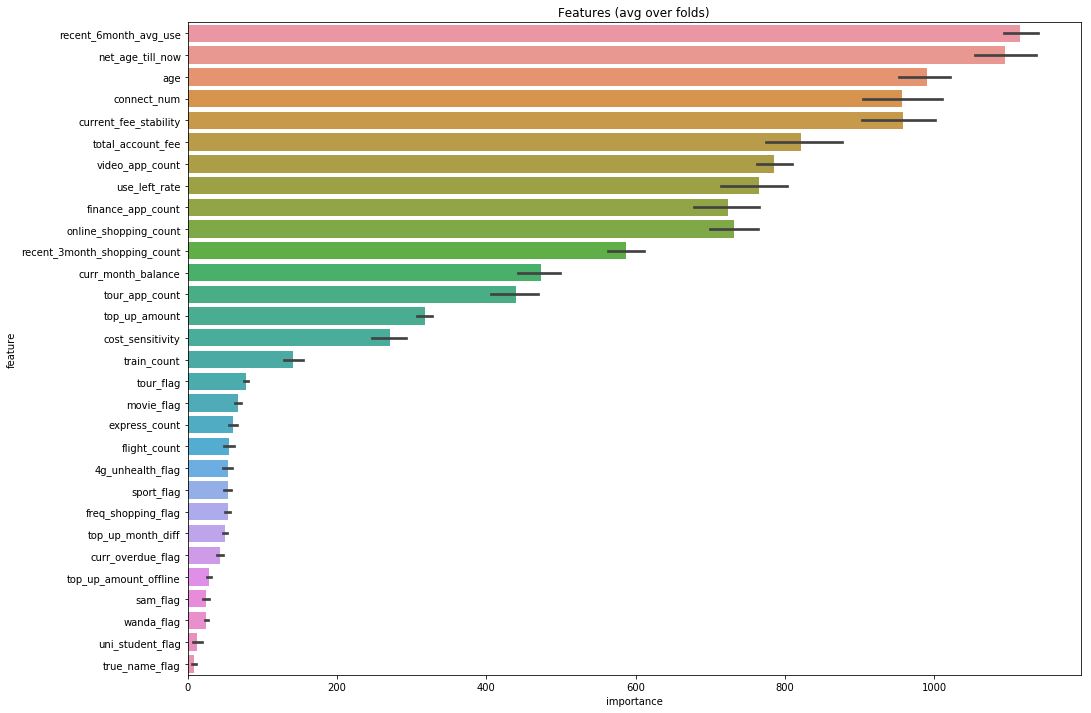

In [26]:
#para
lgb_params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 5,
    'lambda_l2': 5, 'lambda_l1': 0
}

oof_lgb, local_test_lgb, cv_pred_lgb, scores_lgb = train_model(X_train, X_local_test, X_test, train_label, params=lgb_params, folds=folds, model_type='lgb', plot_feature_importance=True)

print("local test acore: ", 1/(1+mean_absolute_error(local_test_label, local_test_lgb)))

Fold 0 started at Sat Mar  9 10:26:52 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
[0]	train-rmse:612.947	valid_data-rmse:612.717
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 50 rounds.


/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[500]	train-rmse:19.4823	valid_data-rmse:20.0067
[1000]	train-rmse:18.2612	valid_data-rmse:19.1734
[1500]	train-rmse:17.8375	valid_data-rmse:19.069
[2000]	train-rmse:17.4767	valid_data-rmse:19.0194
[2500]	train-rmse:17.147	valid_data-rmse:19.0004
Stopping. Best iteration:
[2777]	train-rmse:16.9706	valid_data-rmse:18.9945

Fold 0 mean_absolute_error:  14.725853186069866
Fold 1 started at Sat Mar  9 10:27:14 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
[0]	train-rmse:612.898	valid_data-rmse:612.904
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 50 rounds.
[500]	train-rmse:19.443	valid_data-rmse:20.0868
[1000]	train-rmse:18.2129	valid_data-rmse:19.3575
[1500]	train-rmse:17.7584	valid_data-rmse:19.2857
[2000]	train-rmse:17.383	valid_data-rmse:19.2517
Stopping. Best iteration:
[2134]	train-rmse:17.2926	valid_data-rmse:19.2481

Fold 1 mean_absolute_er

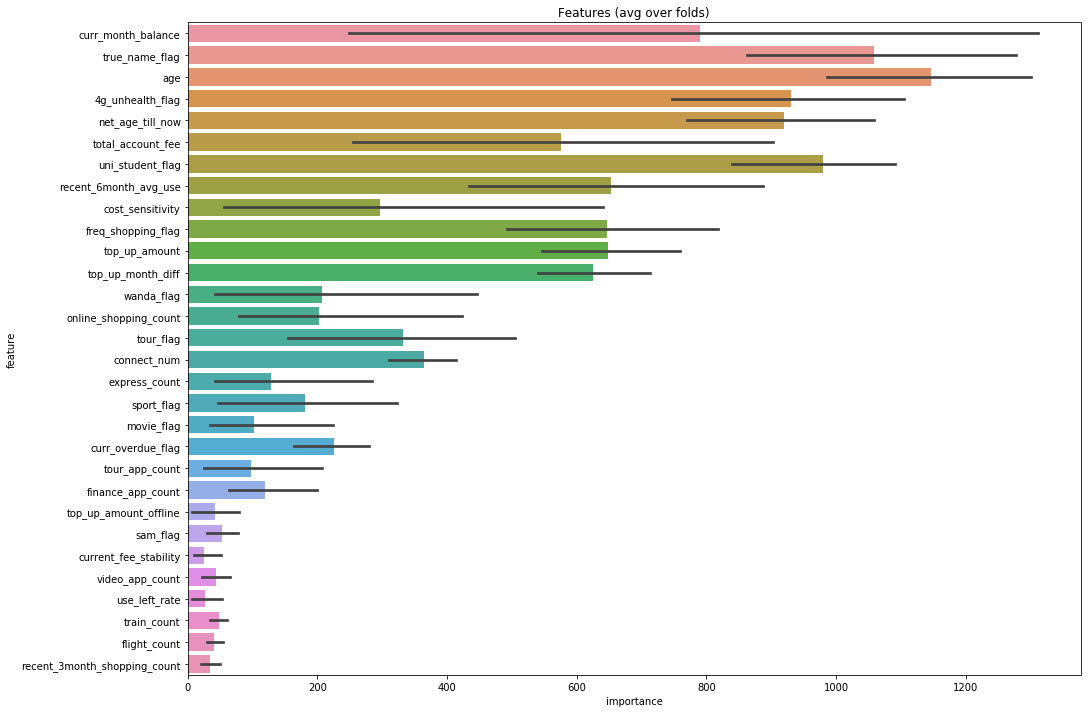

In [30]:
xgb_params = {
        'booster': 'gbtree',
        'learning_rate': 0.01,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.8,
        'objective': 'reg:linear',
        'n_estimators': 10000,
        'min_child_weight': 3,
        'gamma': 0,
        'silent': True,
        'n_jobs': 4,
        'random_state': 4590,
        'reg_alpha': 0,
        'reg_lambda': 5,
        'alpha': 1,
        'verbose': 1
}

oof_xgb, local_test_xgb, cv_pred_xgb, scores_xgb = train_model(X_train, X_local_test, X_test, train_label, params=xgb_params, folds=folds, model_type='xgb', plot_feature_importance=True)

print("local test acore: ", 1/(1+mean_absolute_error(local_test_label, local_test_xgb)))

/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Fold 0 started at Sat Mar  9 10:39:51 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
0:	learn: 613.4444860	test: 613.2234465	best: 613.2234465 (0)	total: 5.65ms	remaining: 56.5s
500:	learn: 20.9516820	test: 20.9907900	best: 20.9907900 (500)	total: 1.39s	remaining: 26.4s
1000:	learn: 19.2074246	test: 19.4043384	best: 19.4043384 (1000)	total: 2.8s	remaining: 25.2s
1500:	learn: 18.7187661	test: 19.1662757	best: 19.1662757 (1500)	total: 4.24s	remaining: 24s
2000:	learn: 18.3716538	test: 19.0531625	best: 19.0530304 (1999)	total: 5.69s	remaining: 22.7s
2500:	learn: 18.0911486	test: 18.9944399	best: 18.9942968 (2499)	total: 7.17s	remaining: 21.5s
3000:	learn: 17.8495533	test: 18.9576884	best: 18.9576884 (3000)	total: 8.6s	remaining: 20.1s
3500:	learn: 17.6260655	test: 18.9368570	best: 18.9368570 (3500)	total: 10.1s	remaining: 18.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 18.92823142
bestIteration = 3707

Shrink model to fir

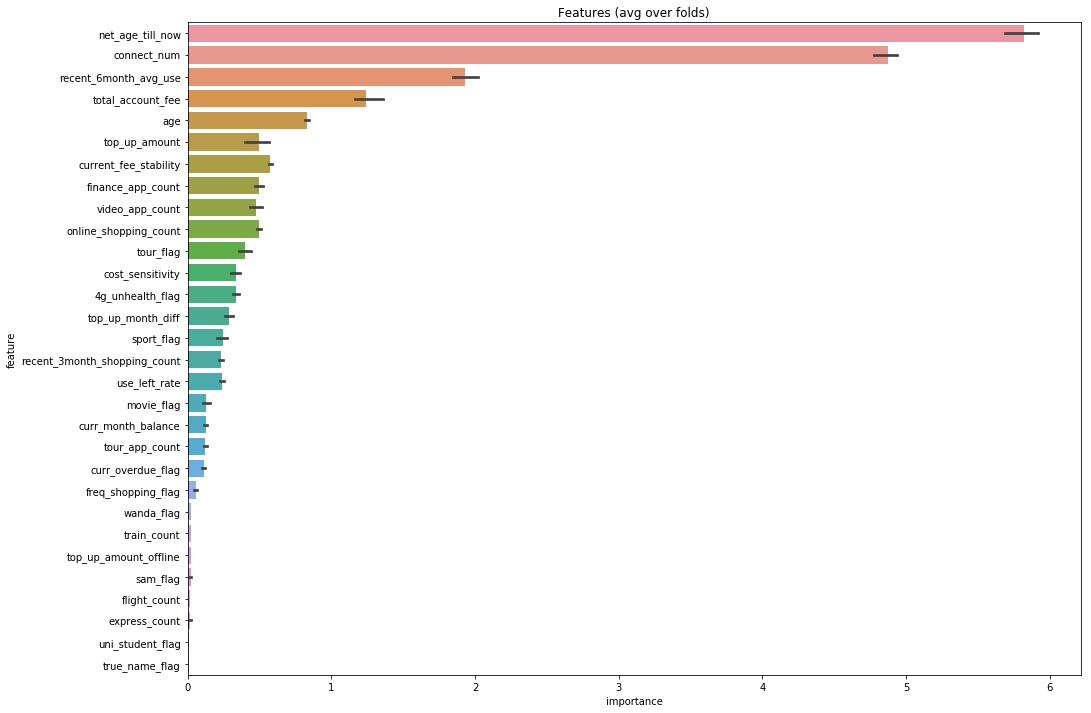

In [43]:
cat_params = {
        'n_estimators': 10000,
        'learning_rate': 0.01,
        'random_seed': 4590,
        'reg_lambda': 0.08,
        'subsample': 0.7,
        'bootstrap_type': 'Bernoulli',
        'boosting_type': 'Plain',
        'one_hot_max_size': 10,
        'rsm': 0.5,
        'leaf_estimation_iterations': 5,
        'use_best_model': True,
        'max_depth': 6,
        'verbose': -1,
        'thread_count': 4
}

oof_cat, local_test_cat, cv_pred_cat, scores_cat = train_model(X_train, X_local_test, X_test, train_label, params=cat_params, folds=folds, model_type='cat', plot_feature_importance=True)

print("local test acore: ", 1/(1+mean_absolute_error(local_test_label, local_test_cat)))